<a href="https://colab.research.google.com/github/greyhound101/Multihead_attention/blob/master/squeezenet_1_5_2413.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [2]:
pip install git+https://github.com/rcmalli/keras-squeezenet.git

  Cloning https://github.com/rcmalli/keras-squeezenet.git to /tmp/pip-req-build-z33ic0ze
  Running command git clone -q https://github.com/rcmalli/keras-squeezenet.git /tmp/pip-req-build-z33ic0ze


In [3]:
import numpy as np
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

In [4]:
!nvidia-smi

Thu Oct 14 02:17:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import zipfile
import h5py
import cv2
from matplotlib import pyplot as plt
import glob, os
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time
import gc
import pandas as pd
import imgaug as ia
from imgaug import augmenters as iaa

import zipfile
import h5py
import cv2
from matplotlib import pyplot as plt
import glob, os
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time
import gc


In [6]:
path = F"/content/gdrive/My Drive/check.npy" 
df=np.load(path,allow_pickle=True)
df=df.item()

In [7]:

#shuffle samples
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



#change targets
def change(img):
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA )
    return resized




#get train and test splits
def get_trn_tst(df,tst_fold):
  idx=np.asarray(df['fold'])
  y=np.asarray(df['label'])
  y-=1
  img=np.asarray(df['image'])
  img1=[]
  for i in range(len(img)):
        img1.append(change(img[i]))
  img1=np.asarray(img1)
  del([img])
  gc.collect()
  trn_y=np.asarray(y[(idx!=tst_fold)])
  trn_img=np.asarray(img1[(idx!=tst_fold)])
  tst_y=np.asarray(y[(idx==tst_fold)])
  tst_img=img1[idx==tst_fold]
  trn_img=np.repeat(trn_img.reshape((trn_img.shape[0],224,224,1)),3,axis=3)
  tst_img=np.repeat(tst_img.reshape((tst_img.shape[0],224,224,1)),3,axis=3)
  return (trn_img.copy(),trn_y.copy()),(tst_img.copy(),tst_y.copy())

In [8]:
import zipfile
import h5py
import cv2
import glob, os
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time
import gc
import keras
from keras.activations import softmax
from keras import backend as K
from keras.layers import *

In [9]:
from keras.models import *
from keras.activations import relu
def load_model():   
  
  K.clear_session() 
  mod=SqueezeNet(include_top=True, weights='imagenet')
  d = mod.get_layer('relu_conv10').output
  d = Conv2D(512,1)(d)
  a = mod.get_layer('fire5/concat').output
  a = Conv2D(256,2)(a)
  
  y = Conv2D(16,1)(a)
  x = Conv2D(16,1)(d)
  x = UpSampling2D(size=(2,2))(x)
  x = Add()([y,x])
  x = Lambda(lambda x: relu(x))(x)
  x = Lambda(lambda x: K.mean(x,axis=-1))(x)
  x = Reshape((26,26,-1))(x)
  map = Lambda(lambda x: softmax(x))(x)
  first = Lambda(lambda x: x[0]*x[1])([a,map])

  a = mod.get_layer('fire3/concat').output
  a = Conv2D(256,5)(a)
  y = Conv2D(16,1)(a)
  x = Conv2D(16,1)(d)
  x = UpSampling2D(size=(4,4))(x)
  x = Add()([y,x])
  x = Lambda(lambda x: relu(x))(x)
  x = Lambda(lambda x: K.mean(x,axis=-1))(x)
  x = Reshape((52,52,-1))(x)
  map = Lambda(lambda x: softmax(x))(x)
  second = Lambda(lambda x: x[0]*x[1])([a,map])
    
  first = UpSampling2D(size=(2,2))(first)
  d = UpSampling2D(size=(4,4))(d)
  conc=Concatenate(axis=-1)([d,first,second])
  conc = GlobalMaxPooling2D()(conc)

  conc = Dense(3, activation="softmax")(conc) 
  

  mod=Model(mod.inputs,conc)
  return mod

In [10]:
# from tensorflow import keras
# from keras.activations import softmax
# from tensorflow.keras import backend as K
# import tensorflow as tf
# class LayerNormalization(Layer):
#     def __init__(self, eps=1e-6, **kwargs):
#         self.eps = eps
#         super(LayerNormalization, self).__init__(**kwargs)
#     def build(self, input_shape):
#         self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
#                                      initializer=Ones(), trainable=True)
#         self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
#                                     initializer=Zeros(), trainable=True)
#         super(LayerNormalization, self).build(input_shape)
#     def call(self, x):
#         mean = K.mean(x, axis=-1, keepdims=True)
#         std = K.std(x, axis=-1, keepdims=True)
#         return self.gamma * (x - mean) / (std + self.eps) + self.beta
#     def compute_output_shape(self, input_shape):
#         return input_shape
# class abc(Layer):
#     def __init__(self,inr,size,mo,up,**kwargs):
#         super(abc, self).__init__(**kwargs)
#         self.inr=inr
#         self.mo=mo
#         self.up=up
#         self.size=size
#     def get_config(self):
#         base_config = super(abc, self).get_config()

#     def build(self, input_shape):
#         super(abc, self).build(input_shape)
#         self.cv1 = Conv2D(self.inr,1)
#         self.cv2 = Conv2D(self.inr,1)
#         self.up = UpSampling2D(interpolation='bilinear',size=(self.up,self.up))
#         self.dns1=Dense(1)
#     def call(self, img,y):
#         y = self.cv1(y)
#         x = self.cv2(img)
#         y = self.up(y)
        
#         x = Add()([y,x])
#         x = ReLU()(x)
#         x = K.mean(x,axis=-1)
#         x = Reshape((self.size,self.size,1))(x)
        
#         map = softmax(x,axis=[2,3])


#         return tf.math.multiply(img,map)

# class SpatialGate(keras.layers.Layer):
#     def __init__(self,**kwargs):
#         super(SpatialGate, self).__init__(**kwargs)

#     def get_config(self):
#         base_config = super(SpatialGate, self).get_config()

#     def build(self, input_shape):
#         super(SpatialGate, self).build(input_shape)
#         self.cv2 = Conv2D(1,1)
#     def call(self, img):
        
#         img_avg = K.expand_dims(K.mean(img,-1),-1)
#         img_max = K.expand_dims(K.max(img,-1),-1)
#         total = Concatenate(-1)([img_avg,img_max])
#         x = self.cv2(total)
#         x = keras.activations.sigmoid(x)

#         return tf.math.multiply(img,x)
# class ChannelGate(keras.layers.Layer):
#     def __init__(self,inr,ratio,**kwargs):
#         super(ChannelGate, self).__init__(**kwargs)
#         self.inr=inr
#         self.ratio=ratio

#     def get_config(self):
#         base_config = super(abc, self).get_config()

#     def build(self, input_shape):
#         super(ChannelGate, self).build(input_shape)
#         self.dns1 = Dense(self.inr/self.ratio,activation='relu')
#         self.dns2 = Dense(self.inr)
#         self.spt = SpatialGate()
#     def call(self, img):
        
#         img_avg = self.dns2(self.dns1(GlobalAveragePooling2D()(img)))
#         img_max = self.dns2(self.dns1(GlobalMaxPooling2D()(img)))
#         x = keras.activations.sigmoid(img_max+img_avg)
#         x = Reshape((1,1,self.inr))(x)

#         return self.spt(tf.math.multiply(img,x))

# from tensorflow import keras 
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import *
# from tensorflow.keras.applications import *
# def load_model():   
  
#   K.clear_session() 
#   mod=densenet.DenseNet121(include_top=True, weights='imagenet')
#   out_1=mod.layers[-2].output
#   out=Dense(3,activation='softmax')(out_1)
#   model=Model(inputs=mod.input,outputs=out)
#   return model


# from tensorflow import keras 
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import *
# from tensorflow.keras.applications import *
# from tensorflow import keras 
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import *
# from tensorflow.keras.applications import *
# def load_model():   
  
#   K.clear_session() 
#   mod=SqueezeNet(include_top=True, weights='imagenet')
#   d = mod.get_layer('relu_conv10').output
#   d = Conv2D(512,1)(d)
#   a = mod.get_layer('fire5/concat').output
#   a = Conv2D(256,2)(a)
  
#   y = Conv2D(16,1)(a)
#   x = Conv2D(16,1)(d)
#   x = UpSampling2D(size=(2,2))(x)
#   x = Add()([y,x])
#   x = Lambda(lambda x: relu(x))(x)
#   x = Lambda(lambda x: K.mean(x,axis=-1))(x)
#   first = Reshape((26,26,-1))(x)

#   a = mod.get_layer('fire3/concat').output
#   a = Conv2D(256,5)(a)
#   y = Conv2D(16,1)(a)
#   x = Conv2D(16,1)(d)
#   x = UpSampling2D(size=(4,4))(x)
#   x = Add()([y,x])
#   x = Lambda(lambda x: relu(x))(x)
#   x = Lambda(lambda x: K.mean(x,axis=-1))(x)
#   second = Reshape((52,52,-1))(x)
#   conc=Concatenate(axis=-1)([a,first,second])
#   conc = GlobalMaxPooling2D()(conc)

#   conc = Dense(3, activation="softmax")(conc) 
  

#   mod=Model(mod.inputs,conc)
#   return mod



# import keras
# import pandas as pd
# from keras.applications.nasnet import NASNetMobile, preprocess_input
import imgaug as ia
from imgaug import augmenters as iaa

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
def Hflip( images):
		seq = iaa.Sequential([iaa.Fliplr(1.0)])
		return seq.augment_images(images)
def Vflip( images):
		seq = iaa.Sequential([iaa.Flipud(1.0)])
		return seq.augment_images(images)
def noise(images):
    ls=[]
    for i in images:
        x = np.random.normal(loc=0, scale=0.05, size=(299,299,3))
        ls.append(i+x)
    return ls
def rotate(images):
    ls=[]
    for angle in range(-15,20,5):
        for image in images:
            ls.append(rotate_image(image,angle))
    return ls
import tensorflow as tf
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.labels       = labels              # array of labels
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(self.labels.shape[0] / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(self.labels.shape[0])

  def __getitem__(self, index):
		# selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    # select data and load images
    labels = self.labels.loc[indexes]
    img = [self.images[k].astype(np.float32) for k in indexes]
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    images=[]
    images.extend(imgH)
    images.extend(imgV)
    images.extend(imgR)
    lbl=labels.copy()
    labels=pd.DataFrame()
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    #images = np.array([preprocess_input(img) for img in images])
    return np.asarray(images), labels.values


best_accuracy_last={}
final_accuracy_last={}
history_last={}
answers_last={}
predictions_last={}
predictions_last_best={}
times_last={}


#shuffle samples
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



#change targets
def change(img):
    resized = cv2.resize(img, (227,227), interpolation = cv2.INTER_AREA )
    return resized




#get train and test splits
def get_trn_tst(df,tst_fold):
  idx=np.asarray(df['fold'])
  y=np.asarray(df['label'])
  y-=1
  img=np.asarray(df['image'])
  img1=[]
  for i in range(len(img)):
        img1.append(change(img[i]))
  img1=np.asarray(img1)
  del([img])
  gc.collect()
  trn_y=np.asarray(y[(idx!=tst_fold)])
  trn_img=np.asarray(img1[(idx!=tst_fold)])
  tst_y=np.asarray(y[(idx==tst_fold)])
  tst_img=img1[idx==tst_fold]
  trn_img=np.repeat(trn_img.reshape((trn_img.shape[0],227,227,1)),3,axis=3)
  tst_img=np.repeat(tst_img.reshape((tst_img.shape[0],227,227,1)),3,axis=3)
  return (trn_img.copy(),trn_y.copy()),(tst_img.copy(),tst_y.copy())

In [11]:

def upd(dk,data):
    if dk==0:
        dk=data
    else:
        for ky in data.keys():
            dk[ky].extend(data[ky])
    return dk

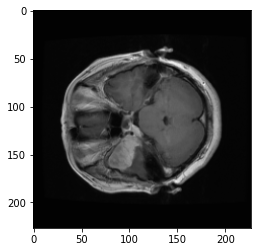

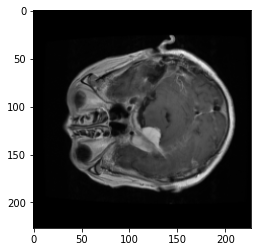

training


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


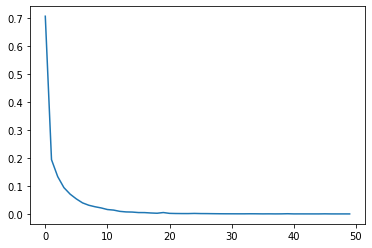

0.9206642066420664


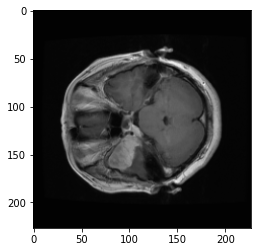

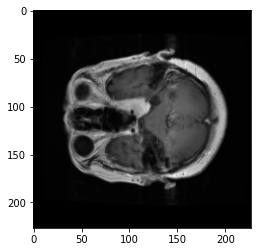

training


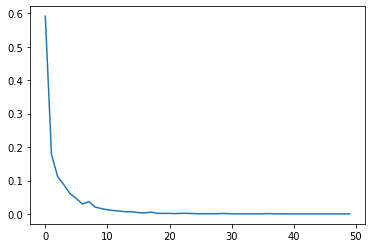

0.9027982326951399


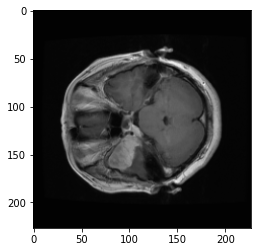

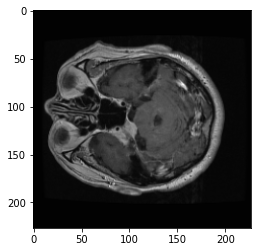

training


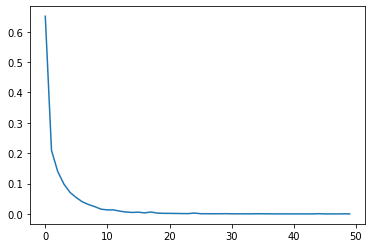

0.951048951048951


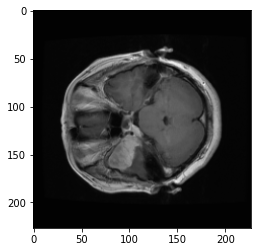

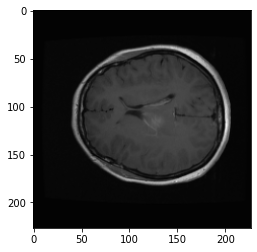

training


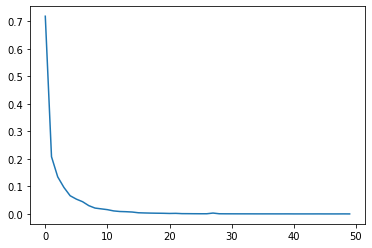

0.9617834394904459


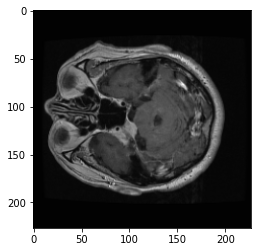

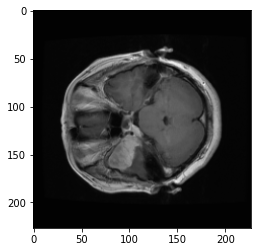

training


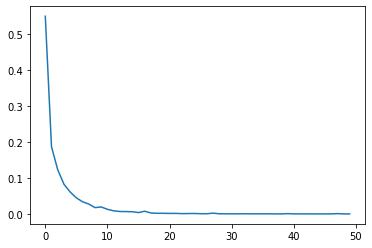

0.926905132192846


In [12]:
from tensorflow.keras.optimizers import Adam
for index in range(1,6):
  best_accuracy_last={}
  final_accuracy_last={}
  history_last={}
  answers_last={}
  predictions_last={}
  predictions_last_best={}
  times_last={}
  epoch=50
  pre_acc=0
  best=0
  fold='fold_'+str(index)
  trn,tst=get_trn_tst(df,index)
  history_last[fold]=0



  plt.imshow(trn[0][0])
  plt.show()
  plt.imshow(tst[0][0])
  plt.show()



  trn_x,trn_y=unison_shuffled_copies(trn[0],trn[1])
  tst_x,tst_y=unison_shuffled_copies(tst[0],tst[1])



  model=load_model()


  
  #compiling the model
  model.compile(optimizer=Adam(2e-4,decay=1e-3), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
  train_data = DataGenerator(trn_x,pd.get_dummies(trn_y), batch_size=4, augment=True)
  ln=len(trn_y)
  # del([trn_x,trn_y,trn,tst])
  # gc.collect()
  #fitting the model
  #timing
  start=time.time()
  print('training')
  hist=model.fit_generator(train_data,epochs=50,steps_per_epoch=ln//4,verbose=0)
  history_last[fold]=upd(history_last[fold],hist.history)

  end=time.time()
  times_last[fold]=end-start

  #getting the prediction 
  pre=model.predict(tst_x)
  



  #select the maximum position
  pre=np.argmax(pre,1)
  predictions_last[fold]=pre

  
  
  
  #getting the accuracy
  new_acc=accuracy_score(pre,tst_y)

  


  #storing the predictions
  final_accuracy_last[fold]=new_acc








  #storing the answers
  answers_last[fold]=tst_y
    
    
    
    
  #freeing memory
  del([tst_x,tst_y])
  gc.collect()

  plt.plot(history_last[fold]['loss'])
  plt.show()
  print(new_acc)
  index=str(index)
  type='squeezenet_'
  model1='xception'
  path='/content/gdrive/My Drive/'
  np.save(path+"/best_accuracy_all_fold_"+index+"_"+model1+"_"+type+".npy",best_accuracy_last)
  np.save(path+'/final_accuracy_all_fold'+index+"_"+model1+"_"+type+".npy",final_accuracy_last)
  np.save(path+'/history_all_fold_'+index+"_"+model1+"_"+type+".npy",history_last)
  np.save(path+'/answers_all_fold_'+index+"_"+model1+"_"+type+".npy",answers_last)
  np.save(path+'/predictions_all_fold_'+index+"_"+model1+"_"+type+".npy",predictions_last)
  np.save(path+'/predictions_all_best_fold_'+index+"_"+model1+"_"+type+".npy",predictions_last_best)
  np.save(path+'/times_all_fold_'+index+"_"+model1+"_"+type+".npy",times_last)
  model.save_weights(path+type+index+'.hdf5')